In [1]:
%matplotlib inline

from __future__ import unicode_literals
import numpy as np
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate
import scipy.integrate as integrate
import scipy.stats as stats
import types
import scipy.constants
# For reading spectrograph spec file
import csv
# Used for function fitting
import lmfit

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'white'
np.set_printoptions(precision=15)

# Helper functions and definitions

In [2]:
def sig_to_fwhm(sig):
    return sig * (2 * np.sqrt(2 * np.log(2)))
def fwhm_to_sig(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def gauss_area(pix_l, pix_r, mu, sigma, amplitude):
    return amplitude * (stats.norm.cdf(pix_r, mu, scale=sigma) - stats.norm.cdf(pix_l, mu, scale=sigma))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

planck = scipy.constants.Planck
c = scipy.constants.c

# Classes that define simulated instruments.

In [3]:
class Order:
    def __init__(self, id, min, max, blaze_peak, res):
        self.id = id
        self.min = min
        self.max = max
        self.blaze_peak = blaze_peak
        self.fsr = self.max - self.min
        self.res = res
        self.fac = self.res / self.fsr
        self.bstrap_err = np.random.normal(0, (50 * self.min * 1e-9) / c) / 1e-9
        self.bstrap_min = self.min + self.bstrap_err
        self.bstrap_max = self.max + self.bstrap_err
        
    def prints(self):
        print('Id: %d' % (self.id))
        print('min: %.16f' % (self.min))
        print('max: %.16f' % (self.max))
        print('fsr: %.16f' % (self.fsr))
        print('fac: %.16f' % (self.fac))
        
    def pix_to_wl(self, pix):
        return self.min + (pix / self.fac)
    
    def wl_to_pix(self, wl):
        return (wl - self.min) * self.fac
    
class Spectrograph:
    def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
        self.orders = []
        
        with open(initFilePath, 'rb') as initFile:
            reader = csv.DictReader(initFile)
            for row in reader:
                id = np.int32(row['order'])
                min = np.float64(row['min'])
                max = np.float64(row['max'])
                blaze_peak = np.float64(row['peak'])
                res = np.int32(np.floor(np.float64(row['length_peak'])))
                self.orders.append(Order(id, min, max, blaze_peak, res))
                
        self.nOrders = len(self.orders)
        self.order_offset = self.orders[0].id
        
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.psf_sigma_studied = self.psf_sigma + np.random.normal(0, self.psf_sigma / 100.0)
        self.precision = precision
        self.blaze = blaze
        
        # Calculate the bootstrap errors of each order
#         startWls = self.minWl + (np.arange(0, self.nOrders) * self.orderSize) 
#         self.bstrap_errs = np.random.normal(0, startWls * fwhm_to_sig(50) / 3e8)
                                            
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    
    def blaze_order(self, wlSpace, obs, fsr, mid):
        sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        return obs * np.exp(-(wlSpace - mid) ** 2 / (2.0 * sigma ** 2)) 
    
    def observe(self, beams, orders='all'):
        space = []
        obs = []
        
        if orders == 'all':
            orders = range(0, self.nOrders)
        
        for i in orders:
            idx = i - self.order_offset
            order = self.orders[idx]
            order_space = np.linspace(order.min, order.max, order.res)
            order_obs = np.zeros(order.res)

            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, order.res) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            pix_ls = np.zeros(order_obs.size)
            pix_rs = np.zeros(order_obs.size)
            pix_width = 1 / order.fac
            for i in range(0, order_space.size):
                pix_ls[i] = order_space[i] - pix_width
                pix_rs[i] = order_space[i] + pix_width
            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                for wl in beam:
                    order_obs += gauss(order_space, wl, self.psf_sigma, beam[wl])
#                     order_obs += gauss_area(pix_ls, pix_rs, wl, self.psf_sigma, beam[wl])
    
            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, len(order_space))
            
            # Blaze
            if self.blaze:
                order_obs = self.blaze_order(order_space, order_obs, order.fsr, order.blaze_peak)
            
#             plt.scatter(order_space, order_obs)
#             plt.show()
            
            space.append(np.linspace(0, order.res, order.res))
            obs.append(order_obs)

        return space, obs
    
class LFC:
    def __init__(self, energy, minWl, maxWl, dWl):
        self.energy = energy
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current_wl = self.minWl
        while current_wl <= self.maxWl:
#             e_photon = (planck * c) / (current_wl * 1e-9) # 1e-9 because wl is in nanometers!
#             photon_count = self.energy / e_photon
#             sim[current_wl] = photon_count
            sim[current_wl] = self.energy
            current_wl += self.dWl
        return sim

# Finding maxima

In [4]:
def get_peaks(shift, order, lfc, n, mode='wl'):
    if mode == 'wl':
        diff = lfc.dWl
    elif mode == 'pix':
        diff = lfc.dWl * order.fac
    else:
        print('Bad mode in peaks')
        return 'error'
    peaks = np.zeros(n)
    current = shift
    for i in range(0, n):
        peaks[i] = current
        current += diff
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=8)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y

def plot_fit(order, lfc, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift, solution_pix):
    fig = plt.figure(1, figsize=(6, 3))
    plt.scatter(ss_x, ss_y, color='magenta', marker='o', facecolors='none')
    plt.scatter(x, y, color='blue', marker='o', facecolors='none')
    plt.plot(ss_x, y_pred, color='blue')
    pred_peaks = get_peaks(pred_shift, order, lfc, len(lfc.getPeaks()), mode='pix')
    pred_peaks = pred_peaks[0:50]
    for peak in pred_peaks:
        plt.axvline(peak, color='green')
#     for peak in lfc_peaks:
#         plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
#     plt.ylim(-100000,800000)
#     plt.axvline(guess_x, color='turquoise')
#     plt.axvline(solution_pix, color='green')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 2 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 8 * lfc.dWl))
    plt.xlim(0, 200)
    plt.xlabel('Pixels')
    plt.ylabel('Pixel counts')
    plt.ylim(-10000, 150000)
    plt.savefig('../figs/fitted2.png')
    return fig

In [5]:
def find_lfc_peaks(x, y, sgraph, lfc, order_id, interpolate, output=True, plot=True, order_model=None):
    order = sgraph.orders[order_id - sgraph.order_offset]
    lfc_peaks = lfc.getPeaks()
    
    lfc_beam = lfc.simulate()
    order_beam = {k: v for k, v in lfc_beam.iteritems() if k >= order.min}
#     print(order_beam)
    solution_wl = min(order_beam.keys())
    solution_pix = order.wl_to_pix(solution_wl)
    if output:
        print('Solution is: {}pix or {}nm'.format(solution_pix, solution_wl))

    
    if interpolate:
        # Do a cubic interpolation of x and y 
        spl = scipy.interpolate.UnivariateSpline(x, y, k=3)
        # ss stands for supersampled
        ss_x = np.linspace(0, order.res, order.res * 5, dtype=np.float64)
        ss_y = spl(ss_x)
    else:
        ss_x = x
        ss_y = y
        
    ss_y[ss_y <= 0.0] = 1e-15
    
    if order_model == None:
        def order_model(wl, minWl):
            maxWl = minWl + order.res
            
            result = per_gauss(wl, sgraph.psf_sigma_studied * order.fac, minWl, maxWl, lfc.dWl * order.fac, np.max(ss_y))

            if sgraph.blaze:
                sigma = order.res / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
                result = result * np.exp(-(wl - (order.res / 2)) ** 2 / (2.0 * sigma ** 2)) 
            return result
        
    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y)
    if output:
        print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), order.pix_to_wl(guess_x)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(order_model)
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', weights=1/np.sqrt(ss_y),
#                       options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
#                                'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', weights=1/np.sqrt(ss_y),
                      options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = order.pix_to_wl(pred_shift)
    
    if output:
        print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
        print('Number of calls: {}'.format(nfev))
    
#     pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
    lse, error = pred_error(ss_y, y_pred, solution_wl, pred_shift_wl)
    if output:
        print('Least squares error is {}'.format(lse))
        print('Error is: {}m/s'.format(error))
    
    fig = None
    if plot:
        fig = plot_fit(order, lfc, x, y, ss_x, ss_y, y_pred, guess_x, pred_shift, solution_pix)
    
    return ss_x, ss_y, y_pred, pred_shift, error, fig, order_model

# Generate sample fitting image

In [6]:
%%time
rand = np.random.random(1)[0]
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, energy, minWl, maxWl, dWl):
lfc = LFC(500 ** 2, sgraph.orders[-1].min + rand, sgraph.orders[0].max - 1 + rand, 0.0214285714) # First order has highest wl!

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 3.39 ms


In [7]:
%%time
interpolate = True
order = 90
lfc_beam = lfc.simulate()
xs, ys = sgraph.observe([lfc_beam], orders=[order])
x = xs[0]
y = ys[0]

CPU times: user 10.5 s, sys: 6.67 ms, total: 10.6 s
Wall time: 10.5 s


Solution is: 2.09937473546pix or 677.207607425nm
Initial guess for shift is: [ 2.000057696745904]pix or 677.207499033nm
 - Adding parameter "minWl"
Predicted shift is: [ 2.099374197272454]pix or 677.207607425nm
Number of calls: 11
Least squares error is 1029.23218187
Error is: 0.000260224435195m/s
CPU times: user 17.1 s, sys: 10 ms, total: 17.1 s
Wall time: 17.1 s


/usr/lib/python2.7/site-packages/lmfit/model.py:459: UserWarning: The keyword argument options does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


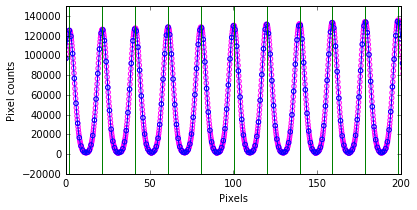

In [8]:
%%time
ss_x, ss_y, y_pred, pred_shift_pix, error, fig, model = find_lfc_peaks(x, y, sgraph, lfc, order, interpolate)

In [12]:
ax = fig.axes[0]
ax.set_xlim(0, 200)
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixel counts')
ax.set_ylim(-20000, 150000)
fig
plt.savefig('fitted.png')

# Figures for EXPRES section

In [ ]:
rand = np.random.random(1)[0]
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(50e-15, sgraph.orders[-1].min + rand - 1, sgraph.orders[0].max + rand + 1, 0.0214285714) # First order has highest wl!
interpolate = True

In [ ]:
%%time
order = 90
lfc_beam = lfc.simulate()
xs, ys = sgraph.observe([lfc_beam], orders=[order])
x_90 = xs[0]
y_90 = ys[0]
ss_x_90, ss_y_90, y_pred_90, pred_shift_90, error_90, fig_90, model_90 = find_lfc_peaks(x_90, y_90, sgraph, lfc, order,
                                                                         interpolate, output=True, plot=False)
%store ss_x_90
%store ss_y_90
%store x_90
%store y_90
%store y_pred_90
%store pred_shift_90
%store error_90
%store fig_90

In [ ]:
%%time
order = 59
lfc_beam = lfc.simulate()
xs, ys = sgraph.observe([lfc_beam], orders=[order])
x_59 = xs[0]
y_59 = ys[0]
ss_x_59, ss_y_59, y_pred_59, pred_shift_59, error_59, fig_59, model_59 = find_lfc_peaks(x_59, y_59, sgraph, lfc, order,
                                                                         interpolate, output=True, plot=False)
%store ss_x_59
%store ss_y_59
%store x_59
%store y_59
%store y_pred_59
%store pred_shift_59
%store error_59
%store fig_59

In [ ]:
%%time
order = 28
lfc_beam = lfc.simulate()
xs, ys = sgraph.observe([lfc_beam], orders=[order])
x_28 = xs[0]
y_28 = ys[0]
ss_x_28, ss_y_28, y_pred_28, pred_shift_28, error_28, fig_28, model_28 = find_lfc_peaks(x_28, y_28, sgraph, lfc, order,
                                                                         interpolate, output=True, plot=False)
%store ss_x_28
%store ss_y_28
%store x_28
%store y_28
%store y_pred_28
%store pred_shift_28
%store error_28
%store fig_28

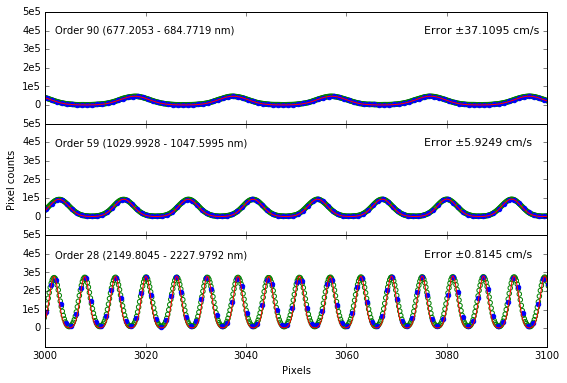

In [38]:
order_90 = sgraph.orders[90 - sgraph.order_offset]
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True)
f.set_size_inches(9,6)
ax1.scatter(ss_x_90, ss_y_90, color='green', marker='o', facecolors='none')
ax1.scatter(x_90, y_90, color='blue', marker='o')
ax1.plot(ss_x_90, y_pred_90, color='red')
ax1.set_xlim(3000, 3100)
# ax1.set_xticklabels([])
ax1.set_ylabel('Pixel counts', position=(0, -0.5))
ax3.set_xlabel('Pixels')
# ax1.set_ylim(-10000, 120000)
ax1.set_yticklabels(['', '0', '1e5', '2e5', '3e5', '4e5', '5e5'])
f.text(0.14, 0.85, 'Order 90 (%.4f - %.4f nm)' % (order_90.min, order_90.max), size=10)
f.text(0.71, 0.85, 'Error ±%.4f cm/s' % (error_90 * 100), size=11)

order_59 = sgraph.orders[59 - sgraph.order_offset]
ax2.scatter(ss_x_59, ss_y_59, color='green', marker='o', facecolors='none')
ax2.scatter(x_59, y_59, color='blue', marker='o')
ax2.plot(ss_x_59, y_pred_59, color='red')
# ax2.set_xlim(3000, 3100)
f.text(0.14, 0.59, 'Order 59 (%.4f - %.4f nm)' % (order_59.min, order_59.max), size=10)
f.text(0.71, 0.59, 'Error ±%.4f cm/s' % (error_59 * 100), size=11)
f.subplots_adjust(hspace=0)

order_28 = sgraph.orders[28 - sgraph.order_offset]
ax3.scatter(ss_x_28, ss_y_28, color='green', marker='o', facecolors='none')
ax3.scatter(x_28, y_28, color='blue', marker='o')
ax3.plot(ss_x_28, y_pred_28, color='red')
# ax3.set_xlim(3000, 3100)
f.text(0.14, 0.33, 'Order 28 (%.4f - %.4f nm)' % (order_28.min, order_28.max), size=10)
f.text(0.71, 0.33, 'Error ±%.4f cm/s' % (error_28 * 100), size=11)
f.subplots_adjust(hspace=0)
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
# plt.savefig('../figs/expres.png')

# Assigning wavelengths to pixels

In [ ]:
bstrap_min = order_58.bstrap.min
bstrap_max = order_58.bstrap.max
# Use bootstrap range to find wl of first and last comb line
real_comb_lines = lfc_beam.keys
pred_line1 = pred_shift_58 # Get location of first line in fitted model
pred_line2 = pred_shift_58 + (lfc.dWl * sgraph.fac) # Get location of second line in fitted model
bstrap_fac = order_58.res / (bstrap_max - bstrap_min)
bstrap_line1_wl = pred_line1 / bstrap_fac + order_58.min # Get wl of line 1 using bootstrap calibration
bstrap_line2_wl = pred_line2 / bstrap_fac + order_58.min # Get wl of line 2 using bootstrap calibration
# Pick line actual wl using known pattern of comb
line1_wl = real_comb_lines[np.argmin(np.abs(real_comb_lines - bstrap_line1_wl))]
line2_wl = real_comb_lines[np.argmin(np.abs(real_comb_lines - bstrap_line2_wl))]

plt.scatter(x, y)
for peak in peaks:
    plt.axvline(peak)
plt.show()

In [ ]:
fwhm = sig_to_fwhm(sgraph.psf_sigma)

# Sensitvity analysis

In [24]:
%%time
# Make a plot of error to SNR
def sensitivity(order_id, sgraph, lfc, attr, nReps, rang, tol=6, **kwargs):
    x = np.zeros(len(rang))
    y = np.zeros((len(rang), nReps))
    print('Running %d times for each value in %s' % (nReps, rang))
    for i, val in enumerate(rang):
        print('Run %d with %f %s' % (i, val, attr))
        if hasattr(lfc, attr):
            setattr(lfc, attr, val)
        elif hasattr(sgraph, attr):
            setattr(sgraph, attr, val)
        else:
            print('Error, bad attribute')
            return
        x[i] = val
        for j in range(0, nReps):
            lfc_beam = lfc.simulate()
            xs, ys = sgraph.observe([lfc_beam], orders=[order_id])
            order_x = xs[0]
            order_y = ys[0]
            err = tol
            fails = 0
            while err >= tol:
                _, _, _, _, err, _, _ = find_lfc_peaks(order_x, order_y, sgraph, lfc, order_id, True, **kwargs)
                if err >= tol:
                    lfc_beam = lfc.simulate()
                    xs, ys = sgraph.observe([lfc_beam], orders=[order_id])
                    order_x = xs[0]
                    order_y = ys[0]
                    fails = fails + 1
                if fails >= 10:
                    break
            y[i][j] = err
    return x,y

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


## SNR sensitivity plot

In [ ]:
%%time
rand = np.random.random(1)[0]
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(200 ** 2, sgraph.orders[-1].min + rand - 1, sgraph.orders[0].max + rand + 1, 0.0214285714) # First order has highest wl!
interpolate = True
rang = [200 ** 2, 400 ** 2, 600 ** 2, 800 ** 2, 1000 ** 2]
# rang = [200 ** 2, 400 ** 2]
print(rang)
order = 90
snr_plot_axis, snr_plot_data = sensitivity(order, sgraph, lfc, 'energy', 20, rang, output=True, plot=True)
# plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%f', np.sqrt(snr_plot_axis)))
# plt.show()
# %store snr_plot_axis
# %store snr_plot_data

In [ ]:
plt.figure(1, figsize=(10,3))
plt.boxplot(np.transpose(snr_plot_data), labels=np.char.mod('%.0f', np.sqrt(snr_plot_axis)))
plt.ylabel('Error in m/s')
plt.xlabel('SNR')
ax = plt.subplot(111)
ax.set_yscale('log')
plt.ylim(1e-4, 1e1)
plt.axhline(0.1, color='black', linestyle='dashed')
plt.figtext(0.6, 0.35, 'Goal precision', size='xx-large')
plt.savefig('../figs/snrverr.png')

# SNR / Resolution Sensitivity Plot

In [ ]:
%%time
# Make a plot of error to SNR
def sensitivity2(order_id, sgraph, lfc, attr, nReps, rang, tol=6, **kwargs):
    x = np.zeros(len(rang))
    y = np.zeros((len(rang), nReps))
    print('Running %d times for each value in %s' % (nReps, rang))
    for i, val in enumerate(rang):
        print('Run %d with %f %s' % (i, val, attr))
        if hasattr(lfc, attr):
            setattr(lfc, attr, val)
        elif hasattr(sgraph, attr):
            setattr(sgraph, attr, val)
        else:
            print('Error, bad attribute')
            return
        x[i] = val
        for j in range(0, nReps):
            lfc_beam = lfc.simulate()
            xs, ys = sgraph.observe([lfc_beam], orders=[order_id])
            order_x = xs[0]
            order_y = ys[0]
            err = tol
            fails = 0
            while err >= tol:
                _, _, _, _, err, _, _ = find_lfc_peaks(order_x, order_y, sgraph, lfc, order_id, True, **kwargs)
                plt.xlim(-50,100)
                plt.show()
                if err >= tol:
                    lfc_beam = lfc.simulate()
                    xs, ys = sgraph.observe([lfc_beam], orders=[order_id])
                    order_x = xs[0]
                    order_y = ys[0]
                    fails = fails + 1
                if fails >= 10:
                    break
            y[i][j] = err
    return x,y

rand = np.random.random(1)[0]
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/snrvres.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(200 ** 2, 677.3, 685, 0.0214285714) # First order has highest wl!
interpolate = True
# rang = [300 ** 2, 500 ** 2, 700 ** 2, 900 ** 2, 1100 ** 2]
rang = [200 ** 2, 300 ** 2, 600 ** 2, 800 ** 2, 1000 ** 2]
# rang = [200 ** 2, 400 ** 2]
print(rang)
snrres_plot_axes = []
snrres_plot_data = []
for i in range(1, 6):
    order = i
    axis, data = sensitivity2(order, sgraph, lfc, 'energy', 20, rang, tol=30, output=True, plot=True)
    snrres_plot_axes.append(axis)
    snrres_plot_data.append(data)
    print(snrres_plot_axes)
    print(snrres_plot_data)
    print('***')

In [ ]:
# %store snrres_plot_axes
# %store snrres_plot_data
f, (ax1) = plt.subplots(1, 1)
f.set_size_inches(5, 5)
ax1.set_yscale('log')
for i in range(0, len(snrres_plot_axes)):
    means = np.zeros(0)
    for j in range(0, len(snrres_plot_data[i])):
        sub = []
        for el in snrres_plot_data[i][j]:
            if el < 100:
                sub.append(el)
        means = np.append(means, np.mean(sub))
    lab = 'Resolution %.0e' % (100000 * i + 100000)
    ax1.plot([2, 4, 6, 8, 10], means, label=lab)
plt.legend(loc=(1.05,0.5), fontsize=11)
ax1.set_xlabel('SNR')
ax1.set_xticks([2, 4, 6, 8, 10])
ax1.set_xticklabels(['200', '400', '600', '800', '1000'])
ax1.set_ylabel('Wavelength calibration error (m/s)')
plt.savefig('../figs/snrresverr.png')

## PSF stability sensitivity plot

Running 20 times for each value in [0.003291121976116074, 0.0032274228410944725, 0.0032061897960872715, 0.0031955732735836715]
Run 0 with 0.003291 psf_sigma
Solution is: 86.755998959pix or 677.3nm
Initial guess for shift is: [ 86.802504038772213]pix or 677.300050755nm
 - Adding parameter "minWl"
Predicted shift is: [ 86.756074331049561]pix or 677.300000082nm
Number of calls: 11
Least squares error is 4101.94797723
Error is: 0.036435666335m/s
Solution is: 86.755998959pix or 677.3nm
Initial guess for shift is: [ 86.802504038772213]pix or 677.300050755nm
 - Adding parameter "minWl"
Predicted shift is: [ 86.756137218864424]pix or 677.300000151nm
Number of calls: 11
Least squares error is 4093.03550368
Error is: 0.0668363290791m/s
Solution is: 86.755998959pix or 677.3nm
Initial guess for shift is: [ 86.802504038772213]pix or 677.300050755nm
 - Adding parameter "minWl"
Predicted shift is: [ 86.755891608719963]pix or 677.299999883nm
Number of calls: 11
Least squares error is 4093.47822041
Err

ValueError: Dimensions of labels and X must be compatible

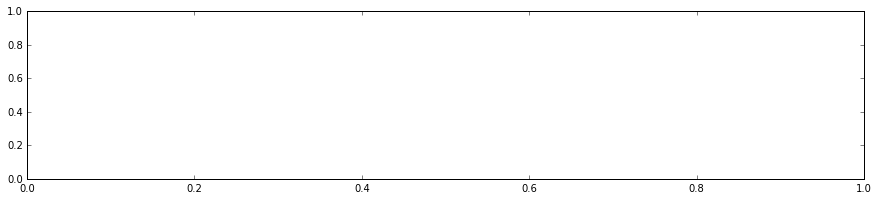

In [25]:
%%time
rand = np.random.random(1)[0]
# def __init__(self, initFilePath, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
sgraph = Spectrograph('../data/expres_specs.csv', 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(500 ** 2, 677.3, 685, 0.0214285714) # First order has highest wl!
interpolate = True

rang = [(0.0075 + (0.0025 / 10)) / (2 * np.sqrt(2 * np.log(2))), 
        (0.0075 + (0.0025 / 25)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 50)) / (2 * np.sqrt(2 * np.log(2))),
        (0.0075 + (0.0025 / 100)) / (2 * np.sqrt(2 * np.log(2)))]
order_id = 90
order = sgraph.orders[order_id - sgraph.order_offset]
model_sigma = sgraph.psf_sigma_studied * order.fac
def model(wl, minWl):
    maxWl = minWl + order.res

    result = per_gauss(wl, model_sigma, minWl, maxWl, lfc.dWl * order.fac, lfc.energy)

    if sgraph.blaze:
        sigma = order.res / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        result = result * np.exp(-(wl - (order.res / 2)) ** 2 / (2.0 * sigma ** 2)) 
    return result

psf_plot_axis, psf_plot_data = sensitivity(order_id, sgraph, lfc, 'psf_sigma', 20, rang, tol=10, plot=False, output=True, order_model=model)
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%e', np.arange(2.7, 3.31, 1/10.0)))
plt.show()

Stored 'psf_plot_axis' (ndarray)
Stored 'psf_plot_data' (ndarray)


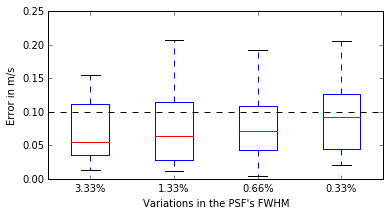

In [43]:
%store psf_plot_axis
%store psf_plot_data
f = plt.figure(1, figsize=(6,3))
plt.boxplot(np.transpose(psf_plot_data), labels=np.char.mod('%.2f', np.asarray([3.1, 3.04, 3.02, 3.01])))
plt.xlabel('Variations in the PSF\'s FWHM')
plt.ylabel('Error in m/s')
ax1 = f.axes[0]
ax1.set_xticklabels(['3.33%', '1.33%','0.66%', '0.33%'])
medians = []
# print(psf_plot_data)
# for i in range(0, len(psf_plot_axis)):
#     medians.append(np.median(psf_plot_data[i]))
# plt.plot([1, 2, 3, 4], medians, color='red')
# plt.scatter([1, 2, 3, 4], medians, color='blue')
plt.axhline(0.1, color='black', linestyle='dashed')
plt.savefig('../figs/stabverr.png')

# Correlation of residuals with shift difference

In [ ]:
%%time
rand = np.random.random(1)[0]
SNR = 1000
n = 100
tol = 100.0
lses = np.zeros(n)
errors = np.zeros(n)
for i in range(0, n):
    print('Run %d:' % (i))
    # def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
    sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
    # def __init__(self, intensity, minWl, maxWl, dWl):
    lfc = LFC(SNR ** 2, 400 + rand, 430 + rand, 1/31.0)
    interpolate = True
    error = tol + 1
    while error >= tol:
        _, _, _, lse, error = find_lfc_peaks(sgraph, lfc, interpolate, output=True, plot=False)
    lses[i] = lse
    errors[i] = error
%store lses
%store errors
plt.scatter(errors, lses)

In [ ]:
def fit(x, m, b):
    return m*x+b
gmod = lmfit.Model(fit)
result = gmod.fit(lses, x=errors, m=1, b=0, method='leastsq', options={})
print(result.fit_report())
print(result.ci_report())
preds = result.best_fit
plt.scatter(errors, lses)
plt.plot(errors, preds)
m = result.params['m'].value
b = result.params['b'].value
print('m: %f, b: %f' % (m, b))


In [ ]:
plt.hist(lses)

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity


**Todays notes**:
Stop plot at SNR 500 (intensity 250,000)


**Ask tyler for specs of EXPRESS**
IOP paper guidelines

In [ ]:
plt.boxplot(np.transpose(y), labels=x)
plt.ylim(0,3)
plt.show()

In [ ]:
print(y)

# Using energy instead of SNR directly

In [ ]:
hc = 1.9864458e-25
integ = integrate.quad(lambda wl: gauss(wl, 0, 4, 1), -np.inf, np.inf)
# x = np.linspace(-20, 20, 1000)
# y = gauss(x, 0, 4, 1)
# plt.hist(y, 100)
# plt.plot(x,y)
print(integ[0])
# k = laser_E / photon_energy
laser_e = 12
wl = 400e-9
k = (laser_e / (hc / wl)) / integ[0]
k

# Failed code to use multiple orders in fitting: impossible!

In [ ]:
def find_lfc_peaks_mult_orders(sgraph, lfc, orderId):
    lfc_peaks = lfc.getPeaks()
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    space, obs = sgraph.observe([lfc.simulate()])
    
    bottom = False
    top = False
    mid = False
    orders = []
    spaces = []
    # Select relevant orders
    if orderId == 0: # If first order in spectrum
        bottom = True
        orders.append(obs[0])
        spaces.append(space[0])
        if len(obs) > 1:
            orders.append(obs[1])
            spaces.append(space[1])
    elif orderId == len(obs) - 1: # else if last
        top = True
        orders.append(obs[-1])
        spaces.append(space[-1])
        if len(obs) > 1:
            orders.append(obs[-2])
            spaces.append(space[-2])
    else: # else middle order
        mid = True
        orders.append(obs[orderId - 1])
        spaces.append(space[orderId - 1])
        orders.append(obs[orderId])
        spaces.append(space[orderId])
        orders.append(obs[orderId + 1])
        spaces.append(space[orderId + 1])
        
    ss_xres = 5 * sgraph.xres
    ss_xs = np.empty((len(orders), ss_xres))
    ss_ys = np.empty((len(orders), ss_xres))
    prev_range = None
    # Interpolate selected orders
    for i in range(0, len(orders)):
        x = spaces[i]
        y = orders[i]
        
        spl = interpolate.UnivariateSpline(x, y, k=3)
        # This is the tricky part. I need the 'distance' between orders, so that I can
        # align them in pixel space correctly. For now, I am assuming that they are adjacent
#         ss_x = np.linspace(order_range[0], order_range[1], ss_xres, dtype=np.float64)
        ss_x = np.linspace(x[0], x[-1], ss_xres)
        ss_y = spl(ss_x)
        ss_y[ss_y <= 0.0] = 1e-15
        
        ss_xs[i] = ss_x
        ss_ys[i] = ss_y
        
    # Paste orders together
    all_ss_x = np.concatenate(ss_xs)
    all_ss_y = np.concatenate(ss_ys)
    
    # Fit on interpolated data
    def per_gauss_fit(wl, shift):
        # per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, all_ss_x[0] + shift, all_ss_x[-1] + shift, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
    
    def err_func(shift):
        err = 0.0
        # Fit the same per_gauss on each order
        for i in range(0, len(ss_xs)):
            err += np.mean(np.abs(per_gauss_fit(ss_xs[i], shift) - ss_ys[i]))
        return err
        
    guess_x, guess_y = guess_min(ss_xs[0], ss_ys[0])
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    gmod = lmfit.Model(per_gauss_fit)
    # Should weight as well!!
    result = gmod.fit(all_ss_y, wl=all_ss_x, shift=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
    pred_shift = result.params['shift'].value
    all_y_pred = result.best_fit
    nfev = result.nfev
    
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
  
    lse, error = pred_error(all_ss_y, all_y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(all_ss_x, all_ss_y, color='blue')
    plt.plot(all_ss_x, all_y_pred, color='red')
    plt.axvline(guess_x, color='turquoise')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    plt.xlim(7000, 7150)
    fig = plt.show()
    
    return error